In [29]:
# Import necessary libraries
import numpy as np
import pandas as pd
import wfdb
import os
import seaborn as sns
import matplotlib.pyplot as plt
import biosppy.signals.ecg as ecg
from scipy import signal
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.signal import butter, filtfilt, welch

In [30]:
# Define relative path to the dataset
database_path = Path('./dataset/mit-bih-arrhythmia-database-1.0.0')

In [31]:
# Convert Path object to string
record_name_str = str(database_path.joinpath("100"))

In [32]:
# Load ECG signal
record = wfdb.rdrecord(record_name_str, channels=[0])

In [33]:
# Load the annotation file
annotation = wfdb.rdann(record_name_str, 'atr')

In [34]:
# Extract ECG signal and corresponding annotation
ecg_signal = record.p_signal[:, 0]
annotation_index = annotation.sample

In [35]:
# Perform noise cancellation using a bandpass filter
def apply_bandpass_filter(signal, fs, lowcut=0.5, highcut=40, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [36]:
# Apply bandpass filter to the ECG signal
filtered_ecg_signal = apply_bandpass_filter(ecg_signal, record.fs)

In [37]:
# Use biosppy to extract ECG features
ecg_features = ecg.ecg(signal=ecg_signal, sampling_rate=record.fs, show=False)

In [38]:
# Extract relevant features
ecg_df = pd.DataFrame({'ECG_Signal': ecg_signal})

In [39]:
# Create a mask indicating the presence of R peaks at each sample index
rpeak_mask = np.zeros(len(ecg_signal))
rpeak_mask[ecg_features['rpeaks']] = 1

In [40]:
# Time-domain features
ecg_df['Mean'] = ecg_signal.mean()
ecg_df['Std_Dev'] = ecg_signal.std()

In [41]:
# Frequency-domain features using power spectral density (PSD)
frequencies, psd = signal.welch(filtered_ecg_signal, fs=record.fs)
peak_frequency_index = np.argmax(psd)
ecg_df['Peak_Frequency'] = frequencies[peak_frequency_index]
ecg_df['Peak_PSD'] = psd[peak_frequency_index]

In [42]:
# Assign R peak mask to DataFrame column
ecg_df['R_Peak_Present'] = rpeak_mask

In [43]:
# Prepare the dataset with extracted features
df = ecg_df.merge(pd.DataFrame({'Index': annotation_index, 'Label': 1}), how='left', left_index=True, right_on='Index')
df['Label'] = df['Label'].fillna(0).astype(int)  # Filling NaN values in Label column with 0 (normal)

In [44]:
# Split the dataset into training and testing sets
X = df.drop(columns=['Index', 'Label'])
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [46]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_std, y_train)

RandomForestClassifier(random_state=42)

In [47]:
# Make predictions on the test set
y_pred = clf.predict(X_test_std)

In [48]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.9985846153846154
Confusion Matrix:
[[129471     87]
 [    97    345]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    129558
           1       0.80      0.78      0.79       442

    accuracy                           1.00    130000
   macro avg       0.90      0.89      0.89    130000
weighted avg       1.00      1.00      1.00    130000



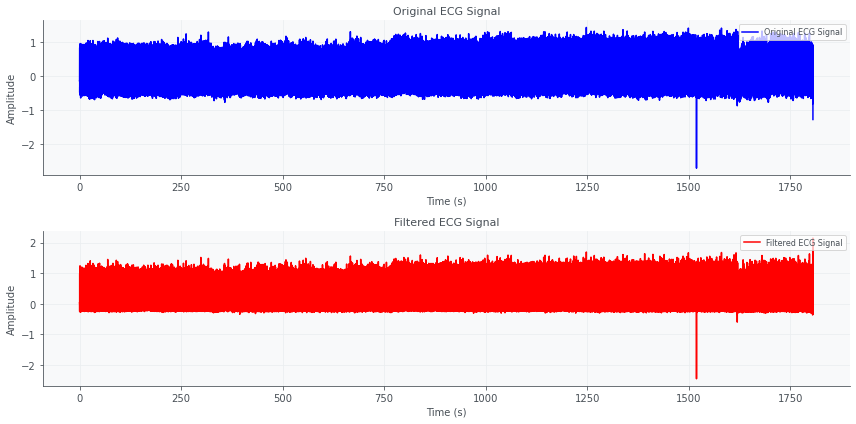

In [49]:
# Visualize original and filtered ECG signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(ecg_signal)) / record.fs, ecg_signal, color='b', label='Original ECG Signal')
plt.title('Original ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(filtered_ecg_signal)) / record.fs, filtered_ecg_signal, color='r', label='Filtered ECG Signal')
plt.title('Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

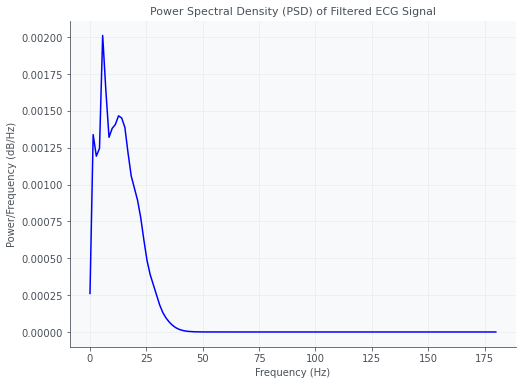

In [50]:
# Plot PSD
plt.figure(figsize=(8, 6))
plt.plot(frequencies, psd, color='b')
plt.title('Power Spectral Density (PSD) of Filtered ECG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

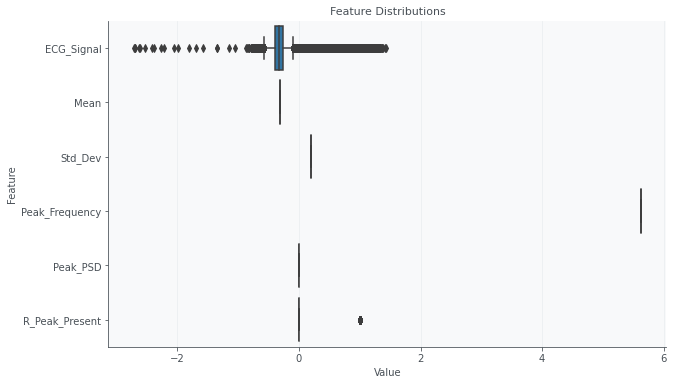

In [51]:
# Plot feature distributions
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, orient='h')
plt.title('Feature Distributions')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.show()

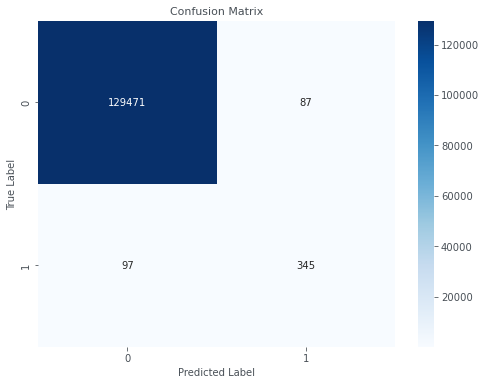

In [52]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()